# Fine-tuning Azure OpenAI GPT-4o for Chart Analysis
This notebook demonstrates the process of vision fine-tuning of GPT-4o leveraging a chart analysis benchmark dataset for visual and logical reasoning. It covers data preparation, fine-tuning, deployment, and evaluation against GPT-4o's baseline performance.

__Content:__
1. Retrieve and prepare dataset
2. Configure and start fine-tuning 
3. Deploy the fine-tuned model
4. Perform infere examples
5. Evaluate model baseline versus fine-tuned performance  

## Setup

In [1]:
import os
import json
from io import BytesIO, StringIO

import pandas as pd
from PIL import Image
import base64
import requests
from IPython.display import display
from tqdm import tqdm
from tenacity import retry, stop_after_attempt, wait_fixed
from dotenv import load_dotenv, find_dotenv
from azure.identity import DefaultAzureCredential
import matplotlib.pyplot as plt

from datasets import load_dataset
from openai import AzureOpenAI

%config InlineBackend.figure_format = 'retina'


In [2]:
# Central variables
project_name = "chart-qa-v4"
train_samples = 8000
val_samples = 1000
test_samples = 800

bold_start, bold_end = '\033[1m', '\033[0m'

SYSTEM_PROMPT = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

if not load_dotenv(find_dotenv()): raise Exception(".env file not found")
api_key = os.getenv("AOAI_KEY")
azure_endpoint = os.getenv("AZURE_ENDPOINT")

# AOAI model deployment using the Control Plane API
subscription_id = os.getenv("SUBSCRIPTION_ID")
resource_name = os.getenv("AOAI_RESOURCE") # name of the AOAI resource
rg_name = os.getenv("RESOURCE_GROUP") # name of the resource group

client = AzureOpenAI(
    api_key=api_key,
    api_version="2024-10-21",
    azure_endpoint=azure_endpoint
)

## Helper functions

In [3]:
def encode_image(image, quality=100):
    """ Encode an image into a base64 string in JPEG format. """

    if image.mode != 'RGB':
        image = image.convert('RGB')  # Convert to RGB
    buffered = BytesIO()
    image.save(buffered, format="JPEG", quality=quality) 
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def date_sorted_df(details_dict):
    """ Create a pandas DataFrame from a dictionary and sort it by a 'created' or 'created_at' timestamp column for displaying OpenAI API tables. """
    df = pd.DataFrame(details_dict)
    
    if 'created' in df.columns:
        df.rename(columns={'created': 'created_at'}, inplace=True)
    
    # Convert 'created_at' from Unix timestamp to human-readable date/time format
    df['created_at'] = pd.to_datetime(df['created_at'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')

    if 'finished_at' in df.columns:
        # Convert 'finished_at' from Unix timestamp to human-readable date/time format, keeping null values as is
        df['finished_at'] = pd.to_datetime(df['finished_at'], unit='s', errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Sort DataFrame by 'created_at' in descending order
    df = df.sort_values(by='created_at', ascending=False)

    return df

def show_ft_metrics(results_df, window_size=5):
    """ Plot fine-tuning metrics including loss and accuracy for training and validation. """

    # Drop rows where valid_loss is NaN or valid_loss is -1.0
    filtered_df = results_df.dropna(subset=['valid_loss'])
    filtered_df = filtered_df.loc[filtered_df['valid_loss'] != -1.0]

    # Compute rolling means
    results_df_smooth = results_df.rolling(window=window_size).mean()
    filtered_df_smooth = filtered_df.rolling(window=window_size).mean()

    # Plot the curves
    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(results_df_smooth['step'], results_df_smooth['train_loss'],  color='blue')
    plt.title('Train Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(results_df_smooth['step'], results_df_smooth['train_mean_token_accuracy'], color='green')
    plt.title('Train Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(filtered_df_smooth['step'], filtered_df_smooth['valid_loss'], color='red')
    plt.title('Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 4)
    plt.plot(filtered_df_smooth['step'], filtered_df_smooth['valid_mean_token_accuracy'], color='orange')
    plt.title('Validation Mean Token Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()


## Retrieve and prepare dataset

Fine-tuning for images is possible with JSONL dataset files similar to the process of sending images as input to the chat completion API.
Images can be provided as HTTP URLs (as shown below) or data URLs containing base64-encoded images.

```json
{
  "messages": [
    { "role": "system", "content": "You are an assistant that identifies uncommon cheeses." },
    { "role": "user", "content": "What is this cheese?" },
    { "role": "user", "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": "https://upload.wikimedia.org/wikipedia/commons/3/36/Danbo_Cheese.jpg"
          }
        }
      ]
    },
    { "role": "assistant", "content": "Danbo" }
  ]
}
```
The following cell converts the ChartQA dataset from HuggingFace into this JSONL format by using base64-encoded images. Depending on your training data format, you will likely need to perform a few changes for reusing the code for your other use cases. 

In [4]:
ds = load_dataset("HuggingFaceM4/ChartQA")
display(ds)

# sample training, validation, and test examples
ds_train = ds['train'].shuffle(seed=42).select(range(train_samples))
ds_val = ds['val'].shuffle(seed=42).select(range(val_samples))
ds_test = ds['test'].shuffle(seed=42).select(range(test_samples))

# convert to pandas dataframe
ds_train = ds_train.to_pandas()
ds_val = ds_val.to_pandas()
ds_test = ds_test.to_pandas()

# convert byte strings to images
ds_train['image'] = ds_train['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))
ds_val['image'] = ds_val['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))
ds_test['image'] = ds_test['image'].apply(lambda x: Image.open(BytesIO(x['bytes'])))

# Convert array type of 'label' column into string only if the current data type is object
if ds_train['label'].dtype == 'object':
    ds_train['label'] = ds_train['label'].apply(lambda x: x[0])

if ds_val['label'].dtype == 'object':
    ds_val['label'] = ds_val['label'].apply(lambda x: x[0])

if ds_test['label'].dtype == 'object':
    ds_test['label'] = ds_test['label'].apply(lambda x: x[0])

# rename columns
ds_train = ds_train.rename(columns={'query': 'question', 'label': 'answer'})
ds_val = ds_val.rename(columns={'query': 'question', 'label': 'answer'})
ds_test = ds_test.rename(columns={'query': 'question', 'label': 'answer'})

# select columns
ds_train = ds_train[['question', 'answer', 'image']]
ds_val = ds_val[['question', 'answer', 'image']]
ds_test = ds_test[['question', 'answer', 'image']]


DatasetDict({
    train: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 28299
    })
    val: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 1920
    })
    test: Dataset({
        features: ['image', 'query', 'label', 'human_or_machine'],
        num_rows: 2500
    })
})

QUESTION: What was the value of loans of FDIC-insured commercial banks secured by real estate in dollars in 2019?


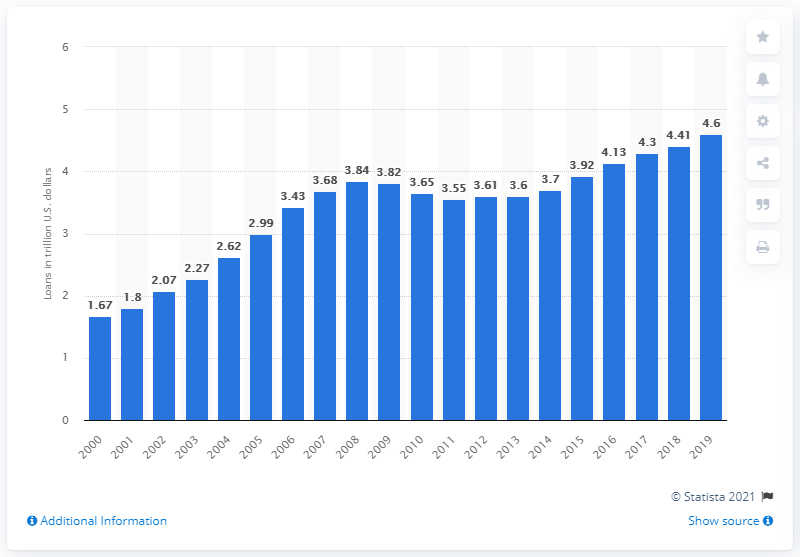

ANSWER: 4.6


In [5]:
# review a random training example
idx=42
print('QUESTION:', ds_train.iloc[idx]['question'])
display(ds_train.iloc[idx]['image'])
print('ANSWER:', ds_train.iloc[idx]['answer'])

In [6]:
# Create dataset splits as local JSONL files
splits = ['train', 'val', 'test']
datasets = [ds_train, ds_val, ds_test]

for split, dataset in zip(splits, datasets):
    dataset_file = f"{project_name}-{split}.jsonl"
    print(f"Generating {dataset_file} with {dataset.shape[0]} samples.")
    
    json_data = []
    base64_prefix = "data:image/jpeg;base64,"
    
    for idx, example in tqdm(enumerate(dataset.itertuples()), total=dataset.shape[0]):
        try:
            system_message = {"role": "system", "content": SYSTEM_PROMPT}
            
            encoded_image = encode_image(example.image, quality=80)
            user_message = {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"Question [{idx}]: {example.question}"},
                    {"type": "image_url", "image_url": {"url": f"{base64_prefix}{encoded_image}"}}
                ]
            }
            assistant_message = {"role": "assistant", "content": example.answer}

            json_data.append({"messages": [system_message, user_message, assistant_message]})
        except KeyError as e:
            print(f"Missing field in example {idx}: {e}")
        except Exception as e:
            print(f"Error processing example {idx}: {e}")
    
    with open(dataset_file, "w") as f:
        for message in json_data:
            json.dump(message, f)
            f.write("\n")

Generating chart-qa-v4-train.jsonl with 8000 samples.


100%|██████████| 8000/8000 [01:17<00:00, 103.11it/s]


Generating chart-qa-v4-val.jsonl with 1000 samples.


100%|██████████| 1000/1000 [00:09<00:00, 105.01it/s]


Generating chart-qa-v4-test.jsonl with 800 samples.


100%|██████████| 800/800 [00:07<00:00, 105.93it/s]


## Configure and start fine-tuning job

In [7]:
# upload training file
train_file = client.files.create(
  file=open(f"{project_name}-train.jsonl", "rb"),
  purpose="fine-tune"
)

# upload validation file
val_file = client.files.create(
  file=open(f"{project_name}-val.jsonl", "rb"),
  purpose="fine-tune"
)

Here is some guidance if you want to adjust the hyperparameters of the fine-tuning process. You can keep them as `None` to use default values. 

| Hyperparameter                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `Batch size`                            | The batch size to use for training. When set to default, batch_size is calculated as 0.2% of examples in training set and the max is 256.                                                           |
| `Learning rate multiplier` | The fine-tuning learning rate is the original learning rate used for pre-training multiplied by this multiplier. We recommend experimenting with values between 0.5 and 2. Empirically, we've found that larger learning rates often perform better with larger batch sizes. Must be between 0.0 and 5.0. |
| `Number of epochs`       | Number of training epochs. An epoch refers to one full cycle through the data set. If set to default, number of epochs will be determined dynamically based on the input data. |
| `Seed`  | The seed controls the reproducibility of the job. Passing in the same seed and job parameters should produce the same results, but may differ in rare cases. If a seed is not specified, one will be generated for you. |

In [8]:
# create fine tuning job
file_train = train_file.id
file_val = val_file.id

ft_job = client.fine_tuning.jobs.create(
  suffix=project_name,
  training_file=file_train,
  # validation file is optional
  validation_file=file_val,
  # baseline model name (not the deployment name)
  model="gpt-4o-2024-08-06",
  seed=None,
  hyperparameters={
    "n_epochs" : None,
    "batch_size" : None,
    "learning_rate_multiplier" : None,
  }
)

In [ ]:
display(ft_job.to_dict())

In [9]:
# List 5 recent fine-tuning jobs
ft_jobs = client.fine_tuning.jobs.list(limit=5).to_dict()

display(date_sorted_df(pd.DataFrame(ft_jobs['data'])))

,id,created_at,hyperparameters,model,object,seed,status,training_file,validation_file,estimated_finish,suffix,result_files,fine_tuned_model,finished_at,trained_tokens
0,ftjob-4103e9763d7b40ac82f9e94fa2b7ba4d,2024-12-01 14:46:39,"{'n_epochs': -1, 'batch_size': -1, 'learning_r...",gpt-4o-2024-08-06,fine_tuning.job,1109274825,pending,file-f9bb60f087cd4f22a2bdc14988d7817f,file-cc8ac046563141f69599ae7b8b2ff3c4,1804812882,chart-qa-v4,NaN,NaN,NaN,NaN
1,ftjob-6c3ece43201e47b2a938f094b540eba8,2024-12-01 13:54:42,"{'n_epochs': 3, 'batch_size': 1, 'learning_rat...",gpt-4o-2024-08-06,fine_tuning.job,436681520,running,file-ebd990a65db74f2ba81234b73a591118,file-19e22a9141194826ab3571269173d1c4,1733942982,v3-chart-qa,[file-d91373a9775e414f97a8ad7fdc69210f],NaN,NaN,NaN
2,ftjob-c0b59c9176b94f49a0edf702e0641652,2024-11-30 16:16:19,"{'n_epochs': 3, 'batch_size': 16, 'learning_ra...",gpt-4o-2024-08-06,fine_tuning.job,1550462918,succeeded,file-00fe878b8f804be894048e388477b7a7,file-615bf3043d3142faa2e4c094c44f0995,1803920479,NaN,[file-b145551262e44a08a870e82ad8362a45],gpt-4o-2024-08-06.ft-c0b59c9176b94f49a0edf702e...,2024-12-01 07:21:29,354682785.0
3,ftjob-e585c1d645ba4a7b943af7d954d62304,2024-11-30 12:30:41,"{'n_epochs': 3, 'batch_size': 1, 'learning_rat...",gpt-4o-2024-08-06,fine_tuning.job,997165443,succeeded,file-ec29db254f8c4be39bfd60a241b135fd,file-0a0857fc7be848ae8768af37a9477d88,1733421941,NaN,[file-e5a048ad7a2f4772a9b6d81d04c0a6be],gpt-4o-2024-08-06.ft-e585c1d645ba4a7b943af7d95...,2024-11-30 13:47:07,2258247.0
4,ftjob-b3bc232f4de54b38917b9f7304903a48,2024-11-30 10:49:14,"{'n_epochs': 3, 'batch_size': 1, 'learning_rat...",gpt-4o-2024-08-06,fine_tuning.job,1795854064,succeeded,file-2d45622be76e40709bf3ade51916915c,file-a033e38633e6401aab06b61a468069c8,1733415854,NaN,[file-d3b2b870720940d0bd7f762d0381bc4a],gpt-4o-2024-08-06.ft-b3bc232f4de54b38917b9f730...,2024-11-30 12:03:53,2258247.0


In [10]:
# Retrieve the state of a fine-tune
ft_job = client.fine_tuning.jobs.retrieve("ftjob-c0b59c9176b94f49a0edf702e0641652")
fine_tuned_model = ft_job.to_dict()['fine_tuned_model']

In [ ]:
ft_job.to_dict()

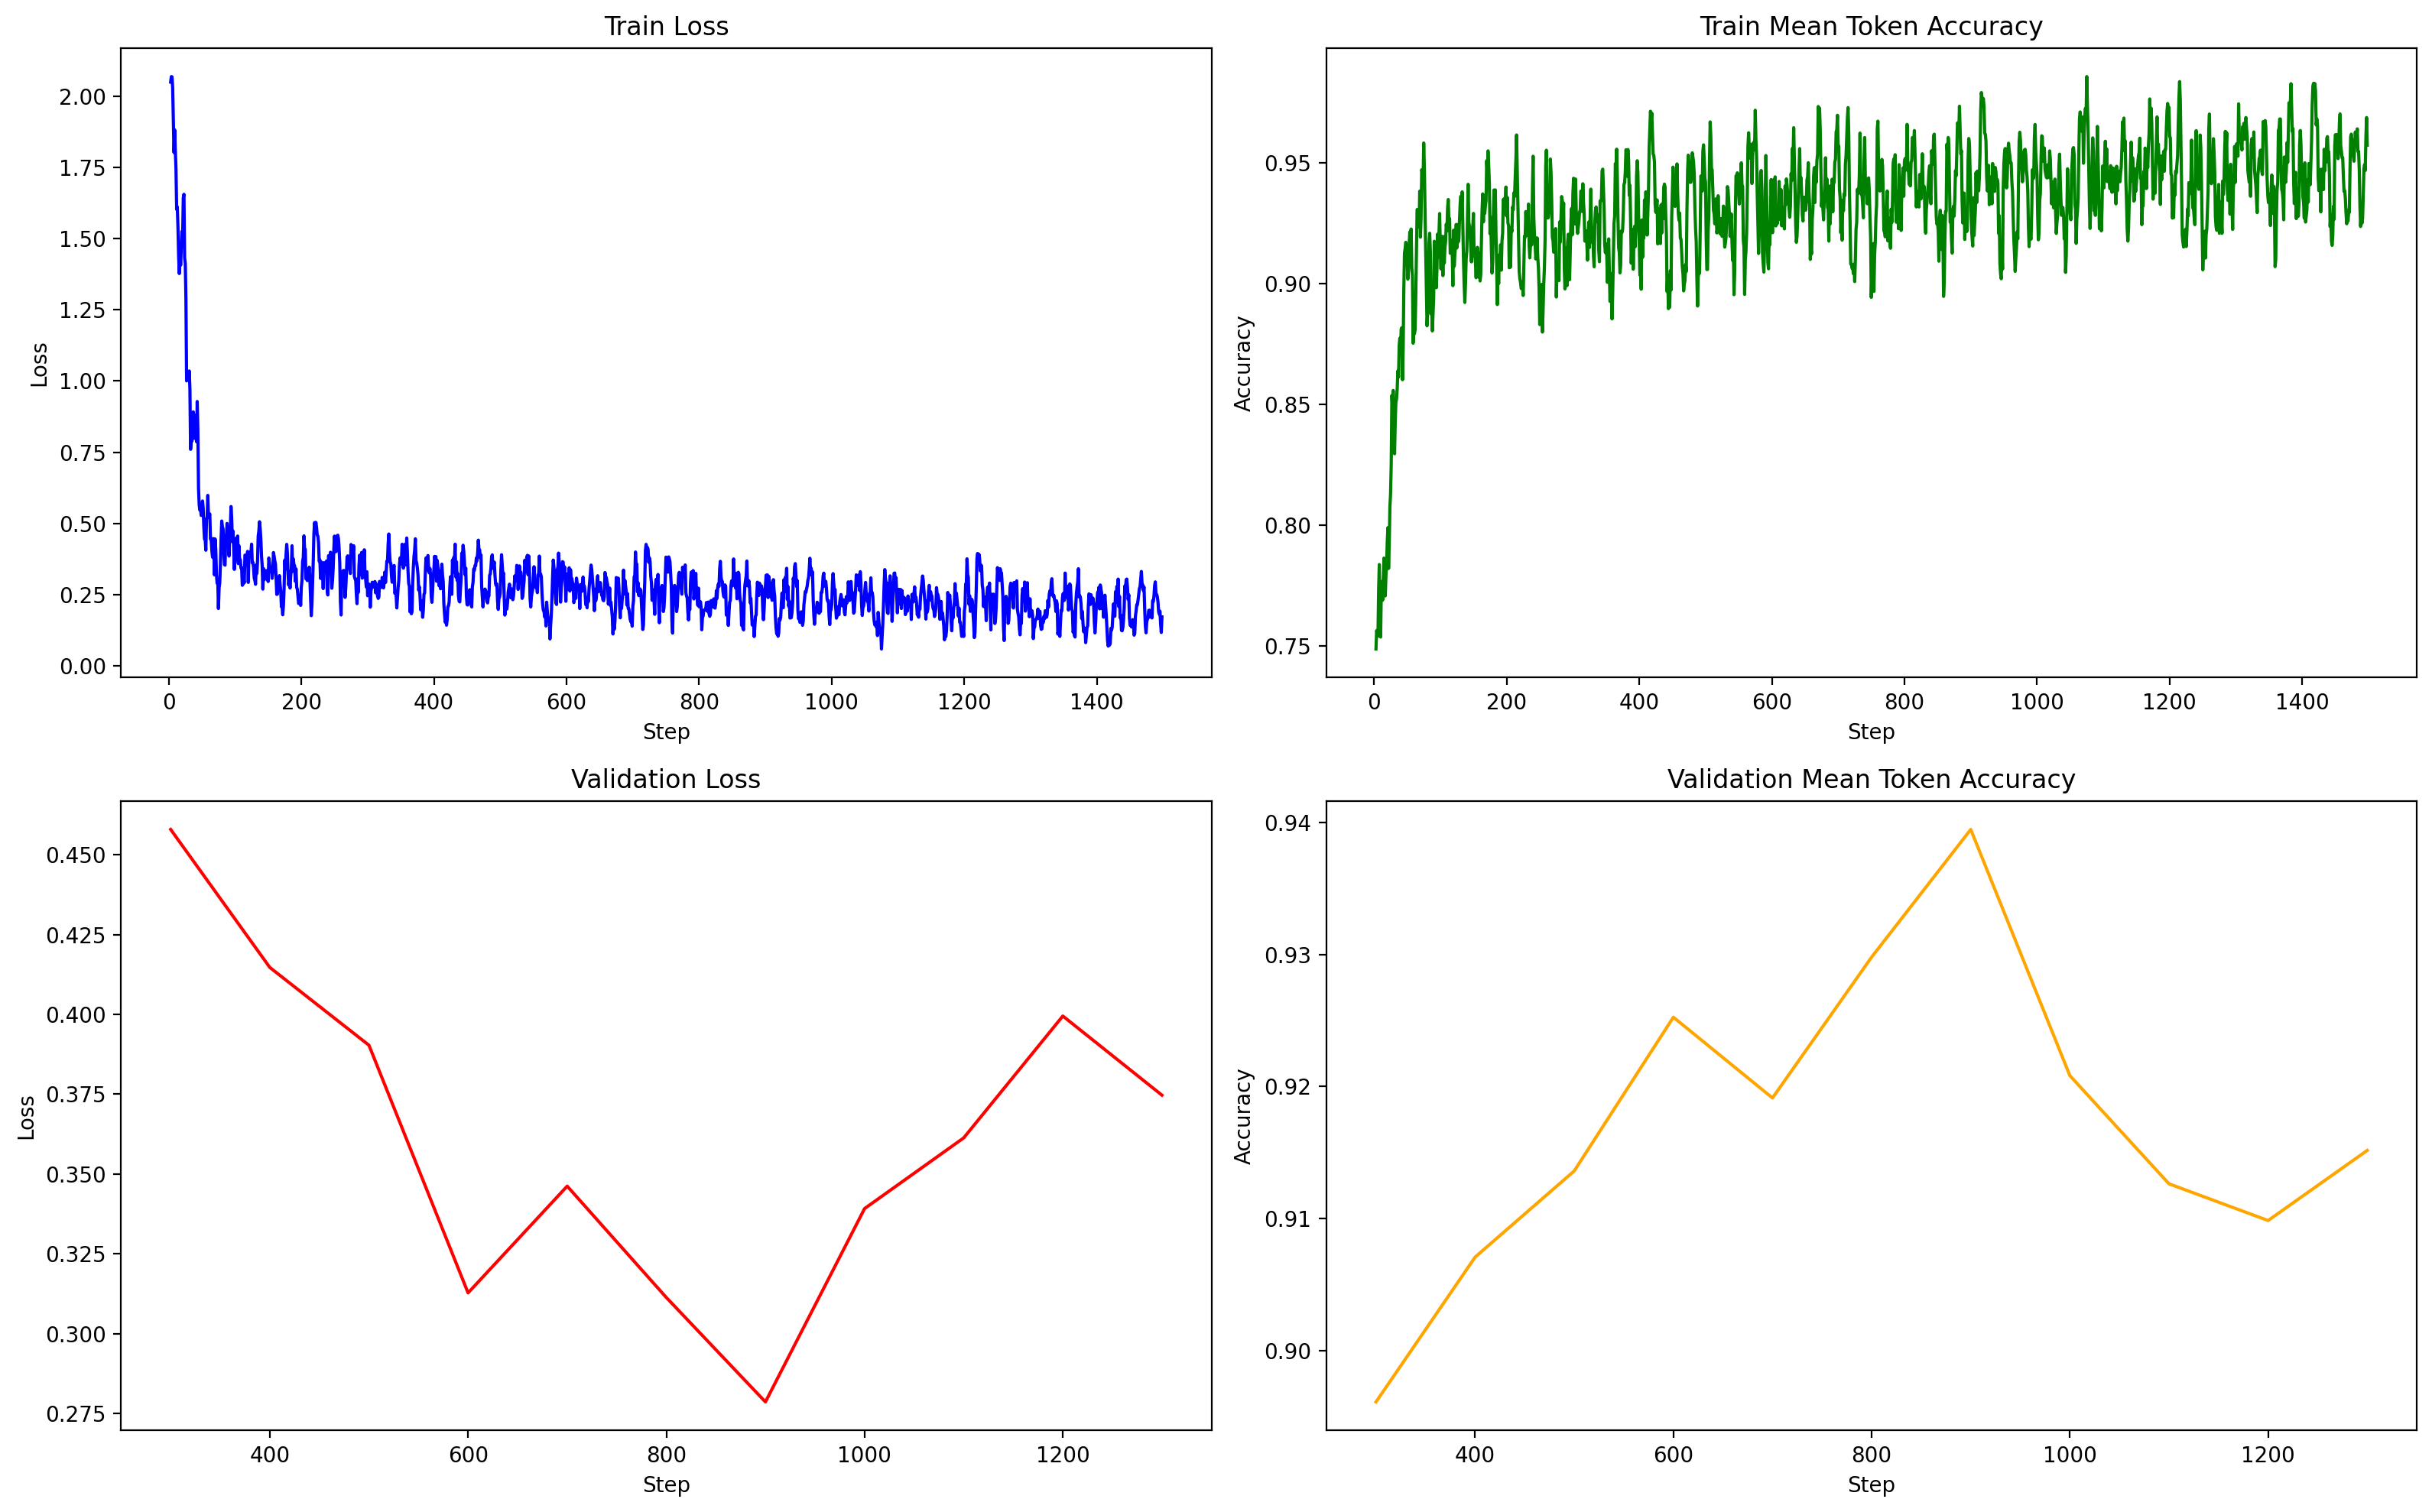

In [11]:
# Retrieve fine-tuning metrics from result file

result_file_id = ft_job.to_dict()['result_files'][0]
results_content = client.files.content(result_file_id).content.decode()

data_io = StringIO(results_content)

results_df = pd.read_csv(data_io)

show_ft_metrics(results_df)

Take a look at this table for an interpretation of above diagrams:  

| Metric                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `step`                            | The number of the training step. A training step represents a single pass, forward and backward, on a batch of training data.                                                           |
| `train_loss`, `validation_loss` | The loss for the training / validation batch |
| `train_mean_token_accuracy`       | The percentage of tokens in the training batch correctly predicted by the model. For example, if the batch size is set to 3 and your data contains completions [[1, 2], [0, 5], [4, 2]], this value is set to 0.83 (5 of 6) if the model predicted [[1, 1], [0, 5], [4, 2]]. |
| `validation_mean_token_accuracy`  | The percentage of tokens in the validation batch correctly predicted by the model. For example, if the batch size is set to 3 and your data contains completions [[1, 2], [0, 5], [4, 2]], this value is set to 0.83 (5 of 6) if the model predicted [[1, 1], [0, 5], [4, 2]]. |

## Deploy fine-tuned model
> __Note__  
> Only one deployment is permitted for a customized model. An error occurs if you select an already-deployed customized model.  

The code below shows how to deploy the model using the Control Plane API. Take a look at the [Azure OpenAI fine-tuning documentation](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning?tabs=turbo&pivots=programming-language-python#deploy-fine-tuned-model) for more details.

In [12]:
# List existing models
my_models = client.models.list().to_dict()

models_df = date_sorted_df(my_models['data'])

cols = ['status', 'capabilities', 'lifecycle_status', 'id', 'created_at', 'model']
print(f'Models of AOAI resource {bold_start}{resource_name}{bold_end}:')
display(models_df[cols].head())

Models of AOAI resource aoai-ak-swece:


,status,capabilities,lifecycle_status,id,created_at,model
88,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-c0b59c9176b94f49a0edf702e...,2024-11-30 16:16:19,gpt-4o-2024-08-06
87,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-c0b59c9176b94f49a0edf702e...,2024-11-30 16:16:19,gpt-4o-2024-08-06
86,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-c0b59c9176b94f49a0edf702e...,2024-11-30 16:16:19,gpt-4o-2024-08-06
85,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-e585c1d645ba4a7b943af7d95...,2024-11-30 12:30:41,gpt-4o-2024-08-06
84,succeeded,"{'fine_tune': False, 'inference': True, 'compl...",generally-available,gpt-4o-2024-08-06.ft-e585c1d645ba4a7b943af7d95...,2024-11-30 12:30:41,gpt-4o-2024-08-06


In [ ]:
aoai_deployment_name = project_name # AOAI deployment name. Use as model parameter for inferencing

credential = DefaultAzureCredential()
token = credential.get_token("https://management.azure.com/.default").token

deploy_params = {'api-version': "2023-05-01"} 
deploy_headers = {'Authorization': 'Bearer {}'.format(token), 'Content-Type': 'application/json'}

deploy_data = {
    "sku": {"name": "standard", "capacity": 1}, 
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": fine_tuned_model, # retrieve this value from the previous calls, it will look like gpt-35-turbo-0613.ft-b044a9d3cf9c4228b5d393567f693b83
            "version": "1"
        }
    }
}
deploy_data = json.dumps(deploy_data)

request_url = f'https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{rg_name}/providers/Microsoft.CognitiveServices/accounts/{resource_name}/deployments/{aoai_deployment_name}'

print('Creating a new deployment...')

r = requests.put(request_url, params=deploy_params, headers=deploy_headers, data=deploy_data)

print(r)
print(r.reason)
print(r.json())

## Test inference

'Which party is least likely to approve NSA surveillance?'

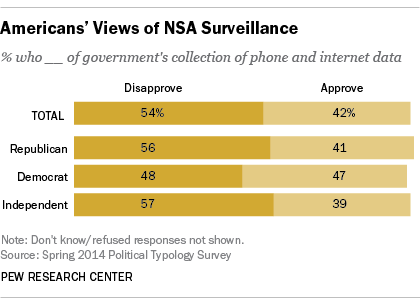

'Independent'

In [13]:
idx = 0

question = ds_test.iloc[idx]['question']
img = ds_test.iloc[idx]['image']
answer = ds_test.iloc[idx]['answer']

display(question)
display(img)
display(answer)

In [14]:
@retry(stop=stop_after_attempt(3), wait=wait_fixed(10))
def query_image(image, question, deployment='gpt-4o'):

    encoded_image_url = f"data:image/jpeg;base64,{encode_image(image, quality=50)}"

    response = client.chat.completions.create(
        model=deployment,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": [
                {"type": "text", "text": question},
                {"type": "image_url", "image_url": {"url": encoded_image_url}}
            ]}
        ],
        temperature=0,
    )

    return response.choices[0].message.content

print(query_image(img, question, 'chart-qa-v2'))

Independent


## Evaluate default versus fine-tuned model

In [ ]:
# Process test dataset with baseline model
ds_test['gpt-4o-base-pred'] = ds_test.apply(lambda row: query_image(row['image'], row['question'], 'gpt-4o'), axis=1)

In [ ]:
# Process test dataset with fine-tuned model
ds_test['gpt-4o-ft-pred'] = ds_test.apply(lambda row: query_image(row['image'], row['question'], 'chart-qa-v2'), axis=1)

# save intermediate results to csv
ds_test.to_csv('evaluation.csv', index=False)

In [ ]:
EVAL_SYSTEM_PROMPT = """You evaluate the factual correctness of a predicted answer about a diagram with a ground truth answer. 
The predicted answer might be formulated in a different way. Your only concern is if the predicted answer is correct from a factual perspective.
You are provided with the original question, the ground truth answer and the predicted answer.
You respond with either CORRECT or INCORRECT"""

@retry(stop=stop_after_attempt(3), wait=wait_fixed(10))
def evaluate(question, ground_truth_answer, predicted_answer, deployment='gpt-4o'):

    user_prompt = f"Original question: {question} \nGround truth answer: {ground_truth_answer}\nPredicted answer: {predicted_answer}" 

    response = client.chat.completions.create(
        model=deployment,
        messages=[
            {"role": "system", "content": EVAL_SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0,
    )

    return response.choices[0].message.content

print(evaluate('what is the diagram title?', 'comparison of tax rates in US states', 'Tax Rate Comparison Across US States'))

In [ ]:
# Validate prediction accuracy of baseline model
ds_test['gpt-4o-base-eval'] = ds_test.apply(lambda row: evaluate(row['question'], row['answer'], row['gpt-4o-base-pred'], 'gpt-4o'), axis=1)

In [ ]:
# Validate prediction accuracy of fine-tuned model
ds_test['gpt-4o-ft-eval'] = ds_test.apply(lambda row: evaluate(row['question'], row['answer'], row['gpt-4o-ft-pred'], 'gpt-4o'), axis=1)

# save final  results to csv
ds_test.to_csv('evaluation.csv', index=False)

In [ ]:
# reload option
ds_test = pd.read_csv('evaluation.csv')

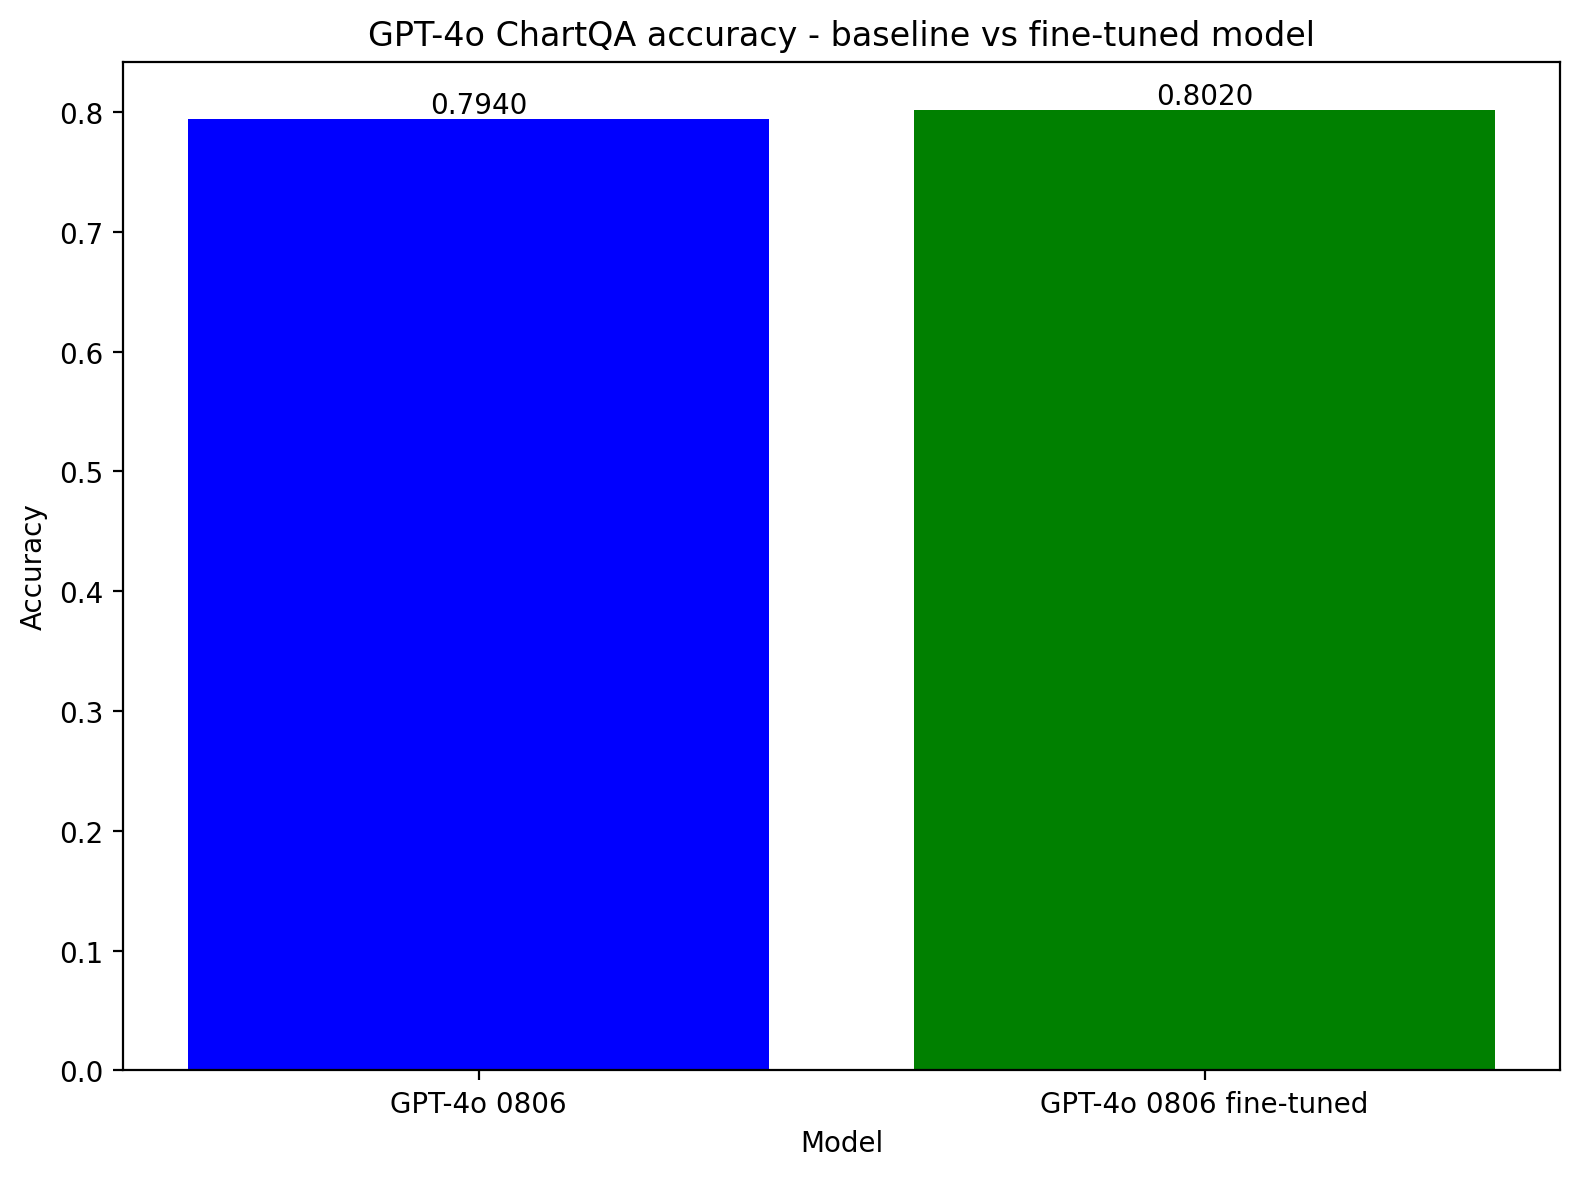

In [16]:
base_correct_count = ds_test['gpt-4o-base-eval'].value_counts().get("CORRECT", 0)
base_eval_observations = ds_test.shape[0]
ft_correct_count = ds_test['gpt-4o-ft-eval'].value_counts().get("CORRECT", 0)
ft_eval_observations = ds_test.shape[0]

chart_data = {
    'title' : 'GPT-4o ChartQA accuracy - baseline vs fine-tuned model', 
    'baseline' : 'GPT-4o 0806',
    'fine-tuned' : 'GPT-4o 0806 fine-tuned',
    'baseline accuracy' : base_correct_count / base_eval_observations,
    'fine-tuned accuracy' : ft_correct_count / ft_eval_observations,
    
}

# Extract data for plotting
models = [chart_data['baseline'], chart_data['fine-tuned']]
accuracies = [chart_data['baseline accuracy'], chart_data['fine-tuned accuracy']]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])

# Add titles and labels
plt.title(chart_data['title'])
plt.ylabel('Accuracy')
plt.xlabel('Model')

# Annotate bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.4f}", ha='center', fontsize=10)

# Display the chart
plt.tight_layout()
plt.show()
